In [27]:
import sys, os

# Notebook 位于 pythontrade/notebooks，project_root 才是 pythontrade
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# 把 project_root 加到模块搜索路径
sys.path.insert(0, project_root)

print(sys.path[0])   # 应该打印 …/pythontrade

# 现在可以这样导入：
from src.data.loader import fetch_ohlcv

/Users/andychen/Desktop/pythontrade


In [28]:
from src.data.loader import fetch_ohlcv
df = fetch_ohlcv("BTC/USDT", "1h")
df.head()

,open,high,low,close,volume
timestamp,,,,,
2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901
2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603
2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809
2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867
2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578


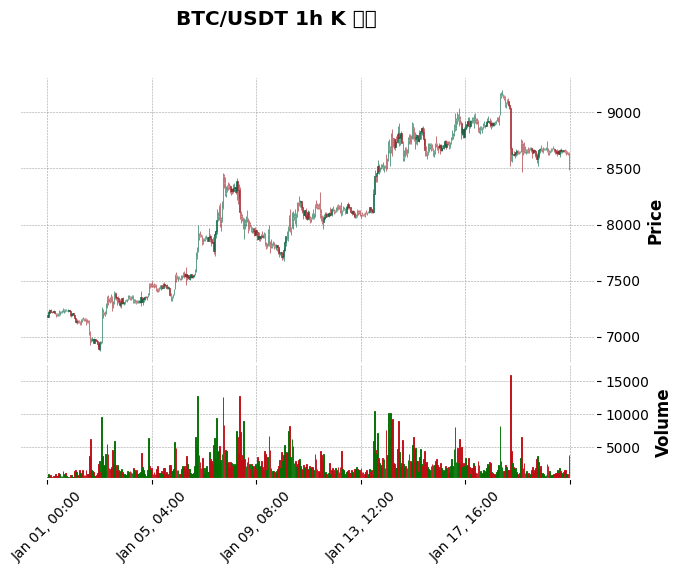

In [29]:
import mplfinance as mpf
import warnings


warnings.filterwarnings("ignore", message="Glyph .* missing from font")
# 画 1h K 线＋成交量
mpf.plot(
    df,
    type="candle",
    volume=True,
    title="BTC/USDT 1h K 线图",
    style="charles"          # 可选主题
)

<Axes: title={'center': 'EMA(5/20) 对比收盘价'}, xlabel='timestamp'>

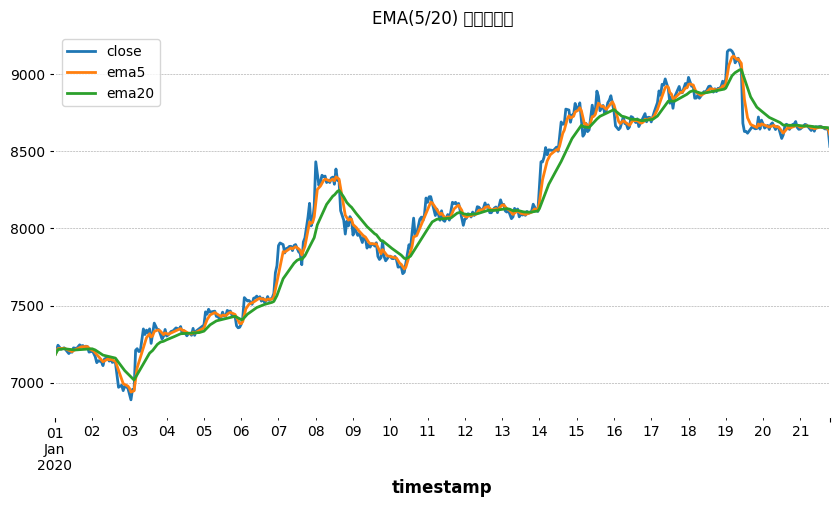

In [30]:
# 先计算两个 EMA
df["ema5"]  = df["close"].ewm(span=5).mean()
df["ema20"] = df["close"].ewm(span=20).mean()

# 然后画折线
df[["close","ema5","ema20"]].plot(
    title="EMA(5/20) 对比收盘价",
    figsize=(10, 5),
    legend=True
)

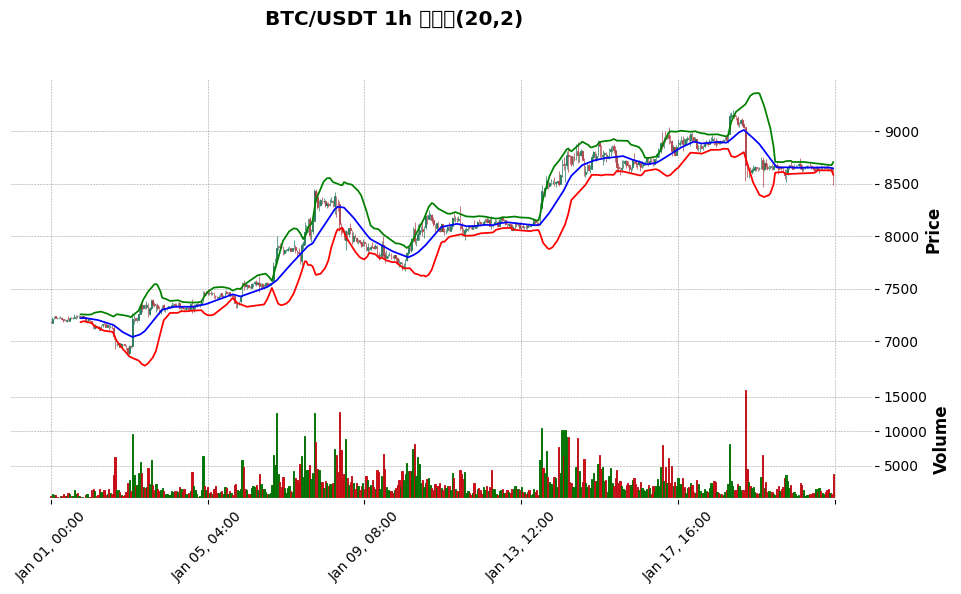

In [31]:
import pandas as pd
import mplfinance as mpf

# 假设你已经有 df
# df = fetch_ohlcv("BTC/USDT", "1h")

# 1. 计算布林带
window = 20
std_factor = 2

df["middle"] = df["close"].rolling(window=window).mean()
df["std"]    = df["close"].rolling(window=window).std()
df["upper"]  = df["middle"] + std_factor * df["std"]
df["lower"]  = df["middle"] - std_factor * df["std"]

# 2. 用 mplfinance 画 K 线并叠加布林带
ap = [
    mpf.make_addplot(df["upper"], color="g"),
    mpf.make_addplot(df["middle"], color="b"),
    mpf.make_addplot(df["lower"], color="r"),
]

mpf.plot(
    df,
    type="candle",
    volume=True,
    addplot=ap,
    title=f"BTC/USDT 1h 布林带({window},{std_factor})",
    style="charles",
    figsize=(12,6)
)

In [32]:
from src.data.loader import fetch_ohlcv

df = fetch_ohlcv("BTC/USDT", "1h")
print(df.head())

                        open     high      low    close      volume
timestamp                                                          
2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02  511.814901
2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27  883.052603
2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85  655.156809
2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01  783.724867
2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27  467.812578


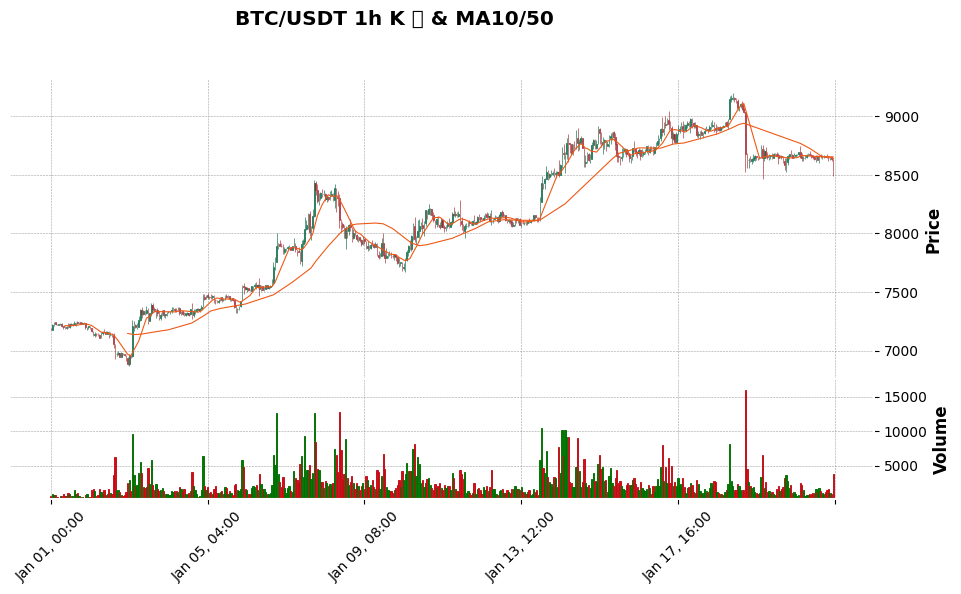

In [33]:
# 如果还没安装 mplfinance，先运行一次：
# pip install mplfinance

import mplfinance as mpf
import pandas as pd
from src.config import DATA_DIR

# 1. 读取已经落盘的 1h 数据
df = pd.read_parquet(DATA_DIR / "BTC_USDT_1h.parquet")

# 2. 用 mplfinance 一步绘制 蜡烛图 + MA10/MA50 + 成交量
mpf.plot(
    df,
    type="candle",        # 蜡烛图
    mav=(10, 50),         # 同时画 10 日和 50 日移动均线
    volume=True,          # 显示成交量
    title="BTC/USDT 1h K 线 & MA10/50",
    style="charles",
    figsize=(12, 6)
)

In [34]:
# from src.data.loader_equities import fetch_stock_ohlcv
# import pandas as pd

# # 拉取苹果近一年的日线
# df = fetch_stock_ohlcv("AAPL", period="1y", interval="1d")

# # 看前几行
# df.head()

# # 画收盘价折线
# df["close"].plot(title="AAPL 日线 收盘价", figsize=(10,4))

In [35]:
import sys


<Axes: title={'center': 'AAPL 日线 收盘价'}, xlabel='timestamp'>

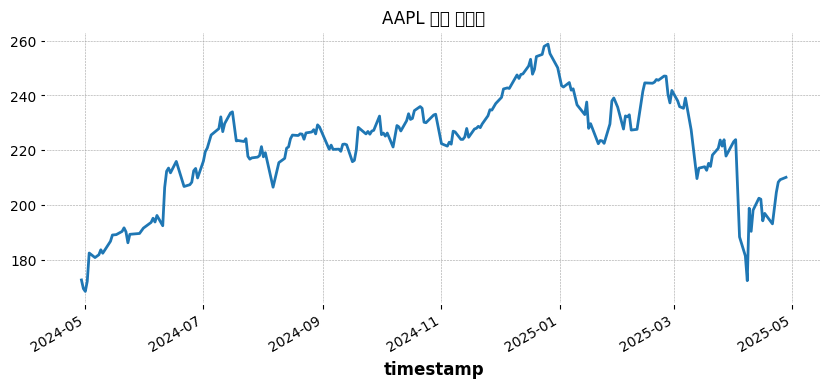

In [36]:
from src.data.loader_equities import fetch_stock_ohlcv
import pandas as pd

# 拉取苹果近一年的日线
df = fetch_stock_ohlcv("AAPL", period="1y", interval="1d")

# 看前几行
df.head()

# 画收盘价折线
df["close"].plot(title="AAPL 日线 收盘价", figsize=(10,4))

timestamp
2025-04-08 07:00:00    79496.00
2025-04-08 08:00:00    79154.02
2025-04-08 09:00:00    78900.00
2025-04-08 10:00:00    79003.54
2025-04-08 11:00:00    79982.00
Name: close, dtype: float64


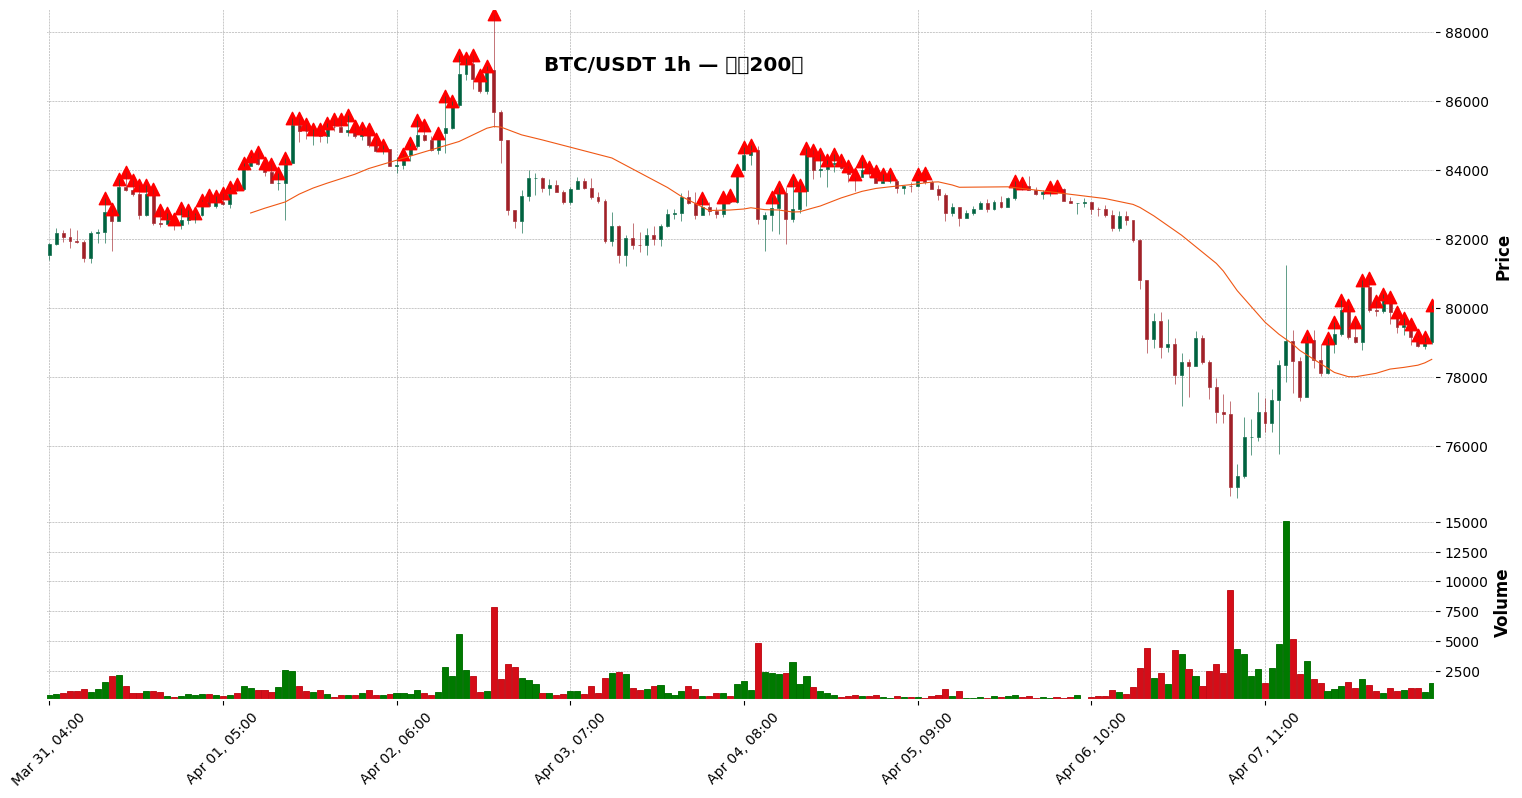

In [37]:
import ccxt
import pandas as pd
import mplfinance as mpf

# ─── 0. 用 ccxt 从 Binance 抓 BTC/USDT 1h K 线 ───────────
exchange = ccxt.binance({"enableRateLimit": True})
# since 参数：从哪天开始拉？这里举例最近 1000 小时
bars = exchange.fetch_ohlcv('BTC/USDT', timeframe='1h', since=exchange.milliseconds() - 1000*60*60*1000)

# 转成 DataFrame
df = pd.DataFrame(bars, columns=['timestamp','open','high','low','close','volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# ─── 1. 生成 ma30 & flag ────────────────────────────────────
df['ma30'] = df['close'].rolling(30).mean()
df['flag'] = df['close'] > df['ma30']

# ─── 2. 取最后 N 根（N<=bars 数量） ─────────────────────────
N = 200
df_sub = df.iloc[-N:].copy()

# 调试：看看最近几根收盘价，确认真的是几万
print(df_sub['close'].tail())

# ─── 3. 准备信号散点层 ─────────────────────────────────────
signal_plot = mpf.make_addplot(
    df_sub['high'].where(df_sub['flag']),
    type='scatter',
    markersize=80,
    marker='^',
    color='red',
    panel=0
)

# ─── 4. 画图 ────────────────────────────────────────────────
mpf.plot(
    df_sub,
    type='candle',
    mav=30,
    volume=True,
    addplot=[signal_plot],
    style='charles',
    figsize=(16, 8),
    title="BTC/USDT 1h — 最新200根",
    tight_layout=True
)


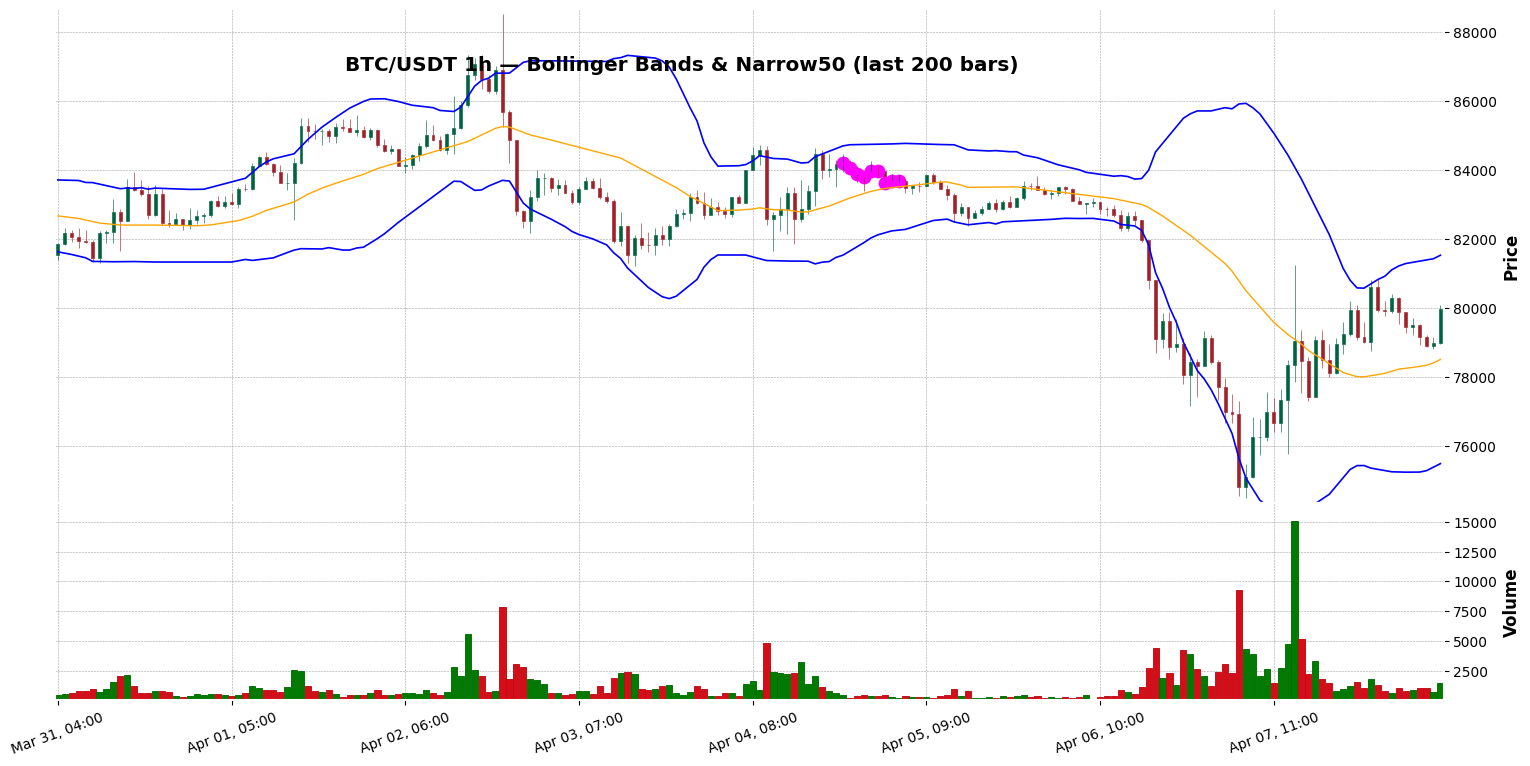

In [38]:
import ccxt
import pandas as pd
import mplfinance as mpf

# ─── 0. 抓取 BTC/USDT 1h 最近 1000 根 K 线 ───────────────────
exchange = ccxt.binance({"enableRateLimit": True})
bars = exchange.fetch_ohlcv(
    'BTC/USDT',
    timeframe='1h',
    since=exchange.milliseconds() - 1000*60*60*1000
)
df = pd.DataFrame(bars, columns=['timestamp','open','high','low','close','volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# ─── 1. 计算布林带 & “收窄 ≥50%” 信号 ─────────────────────────
window = 30
mult   = 2

df['bb_mid']   = df['close'].rolling(window).mean()
df['bb_std']   = df['close'].rolling(window).std()
df['bb_upper'] = df['bb_mid'] + mult * df['bb_std']
df['bb_lower'] = df['bb_mid'] - mult * df['bb_std']
df['bb_width'] = df['bb_upper'] - df['bb_lower']

df['bb_width_past'] = df['bb_width'].shift(window)
df['narrow50']      = df['bb_width'] <= df['bb_width_past'] / 2

# ─── 2. 取最后 200 根展示 ─────────────────────────────────
N = 200
df_sub = df.iloc[-N:].copy()

# ─── 3. 用 make_addplot 准备所有层（注意用 width 而非 linewidth） ───
ap_upper = mpf.make_addplot(
    df_sub['bb_upper'], 
    color='blue', 
    width=1.2, 
    panel=0
)
ap_mid = mpf.make_addplot(
    df_sub['bb_mid'], 
    color='orange', 
    width=1.0, 
    panel=0
)
ap_lower = mpf.make_addplot(
    df_sub['bb_lower'], 
    color='blue', 
    width=1.2, 
    panel=0
)
ap_narrow = mpf.make_addplot(
    df_sub['close'].where(df_sub['narrow50']),  # 只有 narrow50=True 时才有点
    type='scatter',
    marker='o',
    markersize=80,
    color='magenta',
    panel=0
)

# ─── 4. 一次性画蜡烛 + 成交量 + 布林 + 收窄点 ────────────────────
mpf.plot(
    df_sub,
    type='candle',
    volume=True,
    addplot=[ap_upper, ap_mid, ap_lower, ap_narrow],
    style='charles',
    figsize=(16, 8),
    title=f"BTC/USDT 1h — Bollinger Bands & Narrow50 (last {N} bars)",
    tight_layout=True,
    xrotation=20
)






ValueError: O,H,L,C must have the same amount of missing data!

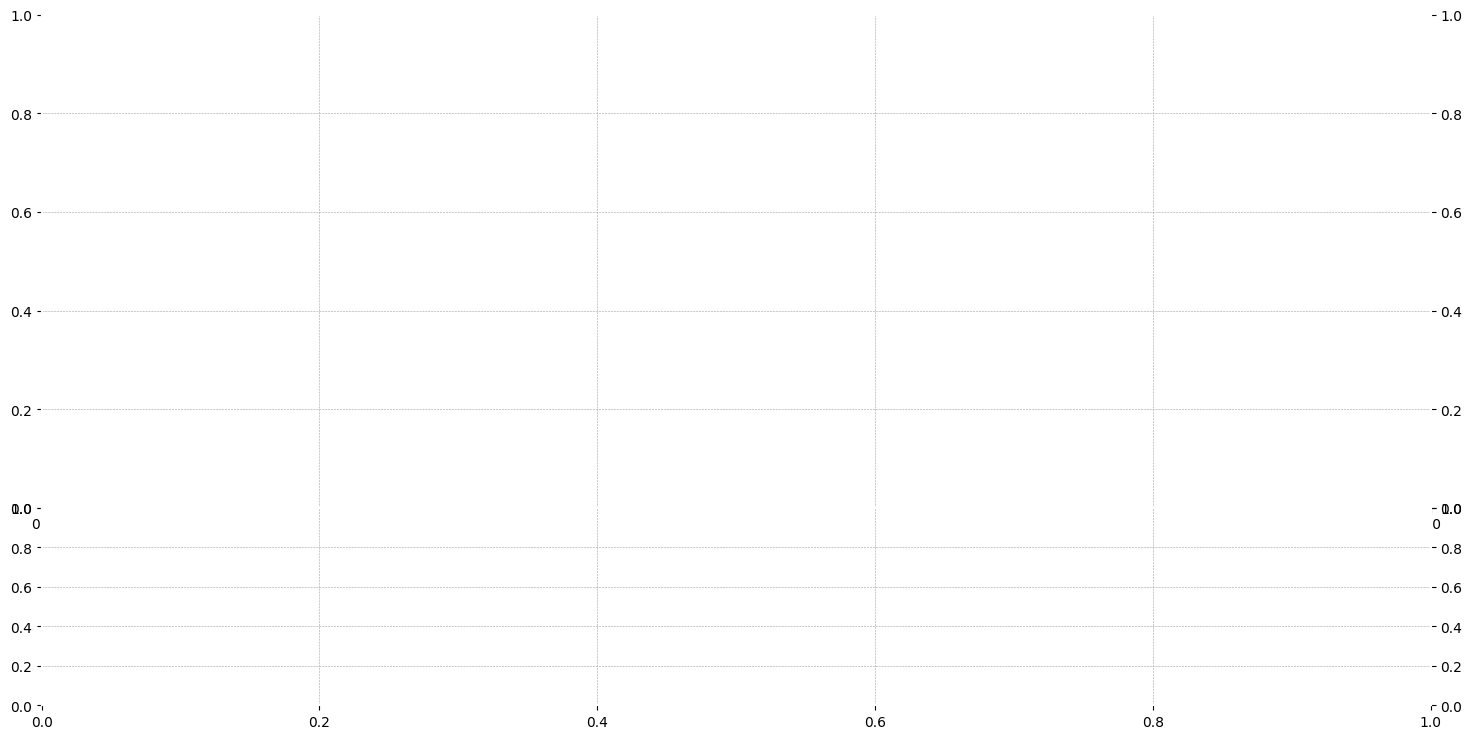

In [ ]:
import ccxt
import pandas as pd
import mplfinance as mpf

# ─── 0. 拉取 BTC/USDT 1h K 线 ───────────────────────────────
exchange = ccxt.binance({"enableRateLimit": True})
bars = exchange.fetch_ohlcv(
    'BTC/USDT',
    timeframe='1h',
    since=exchange.milliseconds() - 2000 * 60 * 60 * 1000  # 最近 2000 小时
)
df = pd.DataFrame(bars, columns=['timestamp','open','high','low','close','volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# ─── 1. 计算 15 周期简单移动平均 ─────────────────────────────
period = 15
df['ma15'] = df['close'].rolling(window=period).mean()

# ─── 2. 取子区间（最后 N 根） ───────────────────────────────
N = 500
df_sub = df.iloc[-N:].copy()

# ─── 3. 找出连续 ≥15 根收盘在均线之上的区间 ────────────────
cond = df_sub['close'] > df_sub['ma15']
dates = df_sub.index
flags = cond.values

runs = []
in_run = False
count = 0

for dt, ok in zip(dates, flags):
    if ok:
        count += 1
        if not in_run:
            start = dt
            in_run = True
    else:
        if in_run and count >= period:
            runs.append((start, prev_dt))
        in_run = False
        count = 0
    prev_dt = dt

if in_run and count >= period:
    runs.append((start, prev_dt))

# ─── 4. 在每段区间之后找第一根高于该区间高点的 K 线 ────────
break_dates = []
for s, e in runs:
    highpt = df_sub.loc[s:e, 'high'].max()
    post   = df_sub.loc[e:].iloc[1:]           # 跳过区间最后一根
    mask   = post['high'] > highpt
    if mask.any():
        break_dates.append(mask.idxmax())

# ─── 5. 构造 addplot 图层 ─────────────────────────────────
# 5.1 15 均线
ap_ma15 = mpf.make_addplot(
    df_sub['ma15'],
    color='purple',
    width=1.2,
    panel=0
)

# 5.2 突破点：先生成一个同索引的浮点序列，只有突破点保留 high 值，其余皆 NaN
signal = df_sub['high'].where(df_sub.index.isin(break_dates))

ap_break = mpf.make_addplot(
    signal,
    type='scatter',
    marker='v',
    markersize=100,
    color='green',
    panel=0
)

# ─── 6. 一次性绘图 ─────────────────────────────────────────
mpf.plot(
    df_sub,
    type='candle',
    volume=True,
    style='charles',
    figsize=(16, 8),
    addplot=[ap_ma15, ap_break],
    title=f"BTC/USDT 1h — MA15 & Breakouts (last {N} bars)",
    tight_layout=True,
    xrotation=20
)




